# resnet迁移学习

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import json
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import numpy as np
import sys
import torchvision.models.resnet

In [2]:
from matplotlib.font_manager import _rebuild
_rebuild()

In [4]:
Fonts = sorted(f.name for f in matplotlib.font_manager.fontManager.ttflist)
for e in Fonts:
    print(e)

NameError: name 'matplotlib' is not defined

In [5]:
import matplotlib
print(matplotlib.matplotlib_fname())
print(matplotlib.get_cachedir())

C:\Users\Administrator\.conda\envs\python3.6env\lib\site-packages\matplotlib\mpl-data\matplotlibrc
C:\Users\Administrator\.matplotlib


In [6]:
plt.rcParams['font.sans-serif']='simsun'

## 数据预处理

In [7]:
datasets_path = "../datasets/海贼王"
os.listdir(datasets_path)

['train', 'val']

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print("using device : {} ".format(device))

using device : cuda:0 


In [9]:
# torchvision数据预处理
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
}

In [10]:
train_dataset = datasets.ImageFolder(os.path.join(datasets_path, "train"), transform=data_transform["train"])

In [11]:
train_num = len(train_dataset)
train_num

435

In [12]:
people_list = train_dataset.class_to_idx
output_channels = len(people_list)
people_list

{'乌索普': 0,
 '乔巴': 1,
 '娜美': 2,
 '山治': 3,
 '布鲁克': 4,
 '弗兰奇': 5,
 '甚平': 6,
 '索隆': 7,
 '罗': 8,
 '罗宾': 9,
 '艾斯': 10,
 '路飞': 11,
 '香克斯': 12}

In [13]:
output_channels

13

In [14]:
# 保存映射关系
people_dict = dict((val, key) for key, val in people_list.items())
json_str = json.dumps(people_dict, indent=4)
json_str

'{\n    "0": "\\u4e4c\\u7d22\\u666e",\n    "1": "\\u4e54\\u5df4",\n    "2": "\\u5a1c\\u7f8e",\n    "3": "\\u5c71\\u6cbb",\n    "4": "\\u5e03\\u9c81\\u514b",\n    "5": "\\u5f17\\u5170\\u5947",\n    "6": "\\u751a\\u5e73",\n    "7": "\\u7d22\\u9686",\n    "8": "\\u7f57",\n    "9": "\\u7f57\\u5bbe",\n    "10": "\\u827e\\u65af",\n    "11": "\\u8def\\u98de",\n    "12": "\\u9999\\u514b\\u65af"\n}'

In [15]:
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

In [16]:
batch_size = 16
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print("using {} dataloader workers every process".format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=nw)

validate_dataset = datasets.ImageFolder(root=os.path.join(datasets_path, "val"),
                                        transform=data_transform["val"])

val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset, 
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=nw)

print("using {} images for training, {} images for validation".format(train_num, val_num))

using 8 dataloader workers every process
using 435 images for training, 72 images for validation


## 导入模型

通过`torchvision`导入`resnet18`模型，并修改最后一层全连接层，调整输出类别为自己数据集的类别，这里按照给出的任务数据集为13

In [17]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)

In [18]:
# 不训练前面的层
constrain = True
for param in resnet18.parameters():
    param.requires_grad = constrain

In [19]:
in_channel = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_channel, output_channels)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
for param in resnet18.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [16]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 模型迁移学习

固定前面层不动，只训练最后这一层全连接层

In [17]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr = 0.0001)

best_acc = 0.0
save_path = "../models/resnet18.pth"
epoches = 20

In [18]:
for epoch in range(epoches):
    resnet18.train()
    training_loss = 0.0
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        optimizer.zero_grad()
        logits = resnet18(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()

    # 模型验证
    resnet18.eval()
    val_acc = 0.0
    with torch.no_grad():
        for val_data in validate_loader:
            val_images, val_labels = val_data
            outputs = resnet18(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            val_acc += (predict_y == val_labels.to(device)).sum().item()
        val_accurate = val_acc / val_num
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(resnet18.state_dict(), save_path)
        print("[epoch %d] train_loss: %.3f test_accuracy: %.3f best_acc: %.3f" % (epoch + 1, training_loss / step, val_accurate, best_acc))
print("finish training")

C:\Users\Administrator\.conda\envs\python3.6env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[epoch 1] train_loss: 2.074 test_accuracy: 0.606
[epoch 2] train_loss: 0.994 test_accuracy: 0.775
[epoch 3] train_loss: 0.608 test_accuracy: 0.859
[epoch 4] train_loss: 0.471 test_accuracy: 0.915
[epoch 5] train_loss: 0.370 test_accuracy: 0.901
[epoch 6] train_loss: 0.412 test_accuracy: 0.901
[epoch 7] train_loss: 0.333 test_accuracy: 0.915
[epoch 8] train_loss: 0.298 test_accuracy: 0.901
[epoch 9] train_loss: 0.319 test_accuracy: 0.972
[epoch 10] train_loss: 0.370 test_accuracy: 0.972
[epoch 11] train_loss: 0.266 test_accuracy: 0.930
[epoch 12] train_loss: 0.205 test_accuracy: 0.915
[epoch 13] train_loss: 0.267 test_accuracy: 0.930
[epoch 14] train_loss: 0.250 test_accuracy: 0.901
[epoch 15] train_loss: 0.200 test_accuracy: 0.901
[epoch 16] train_loss: 0.236 test_accuracy: 0.944
[epoch 17] train_loss: 0.217 test_accuracy: 0.930
[epoch 18] train_loss: 0.175 test_accuracy: 0.944
[epoch 19] train_loss: 0.236 test_accuracy: 0.958
[epoch 20] train_loss: 0.161 test_accuracy: 0.958
finish tr

## 模型导入及测试

In [73]:
json_file = open("class_indices.json", 'r')
class_indice = json.load(json_file)
class_indice

{'0': '乌索普',
 '1': '乔巴',
 '10': '艾斯',
 '11': '路飞',
 '12': '香克斯',
 '2': '娜美',
 '3': '山治',
 '4': '布鲁克',
 '5': '弗兰奇',
 '6': '甚平',
 '7': '索隆',
 '8': '罗',
 '9': '罗宾'}

In [74]:
model = models.resnet18(num_classes=len(class_indice))
model_weight_path = "../models/resnet18.pth"
model.load_state_dict(torch.load(model_weight_path, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

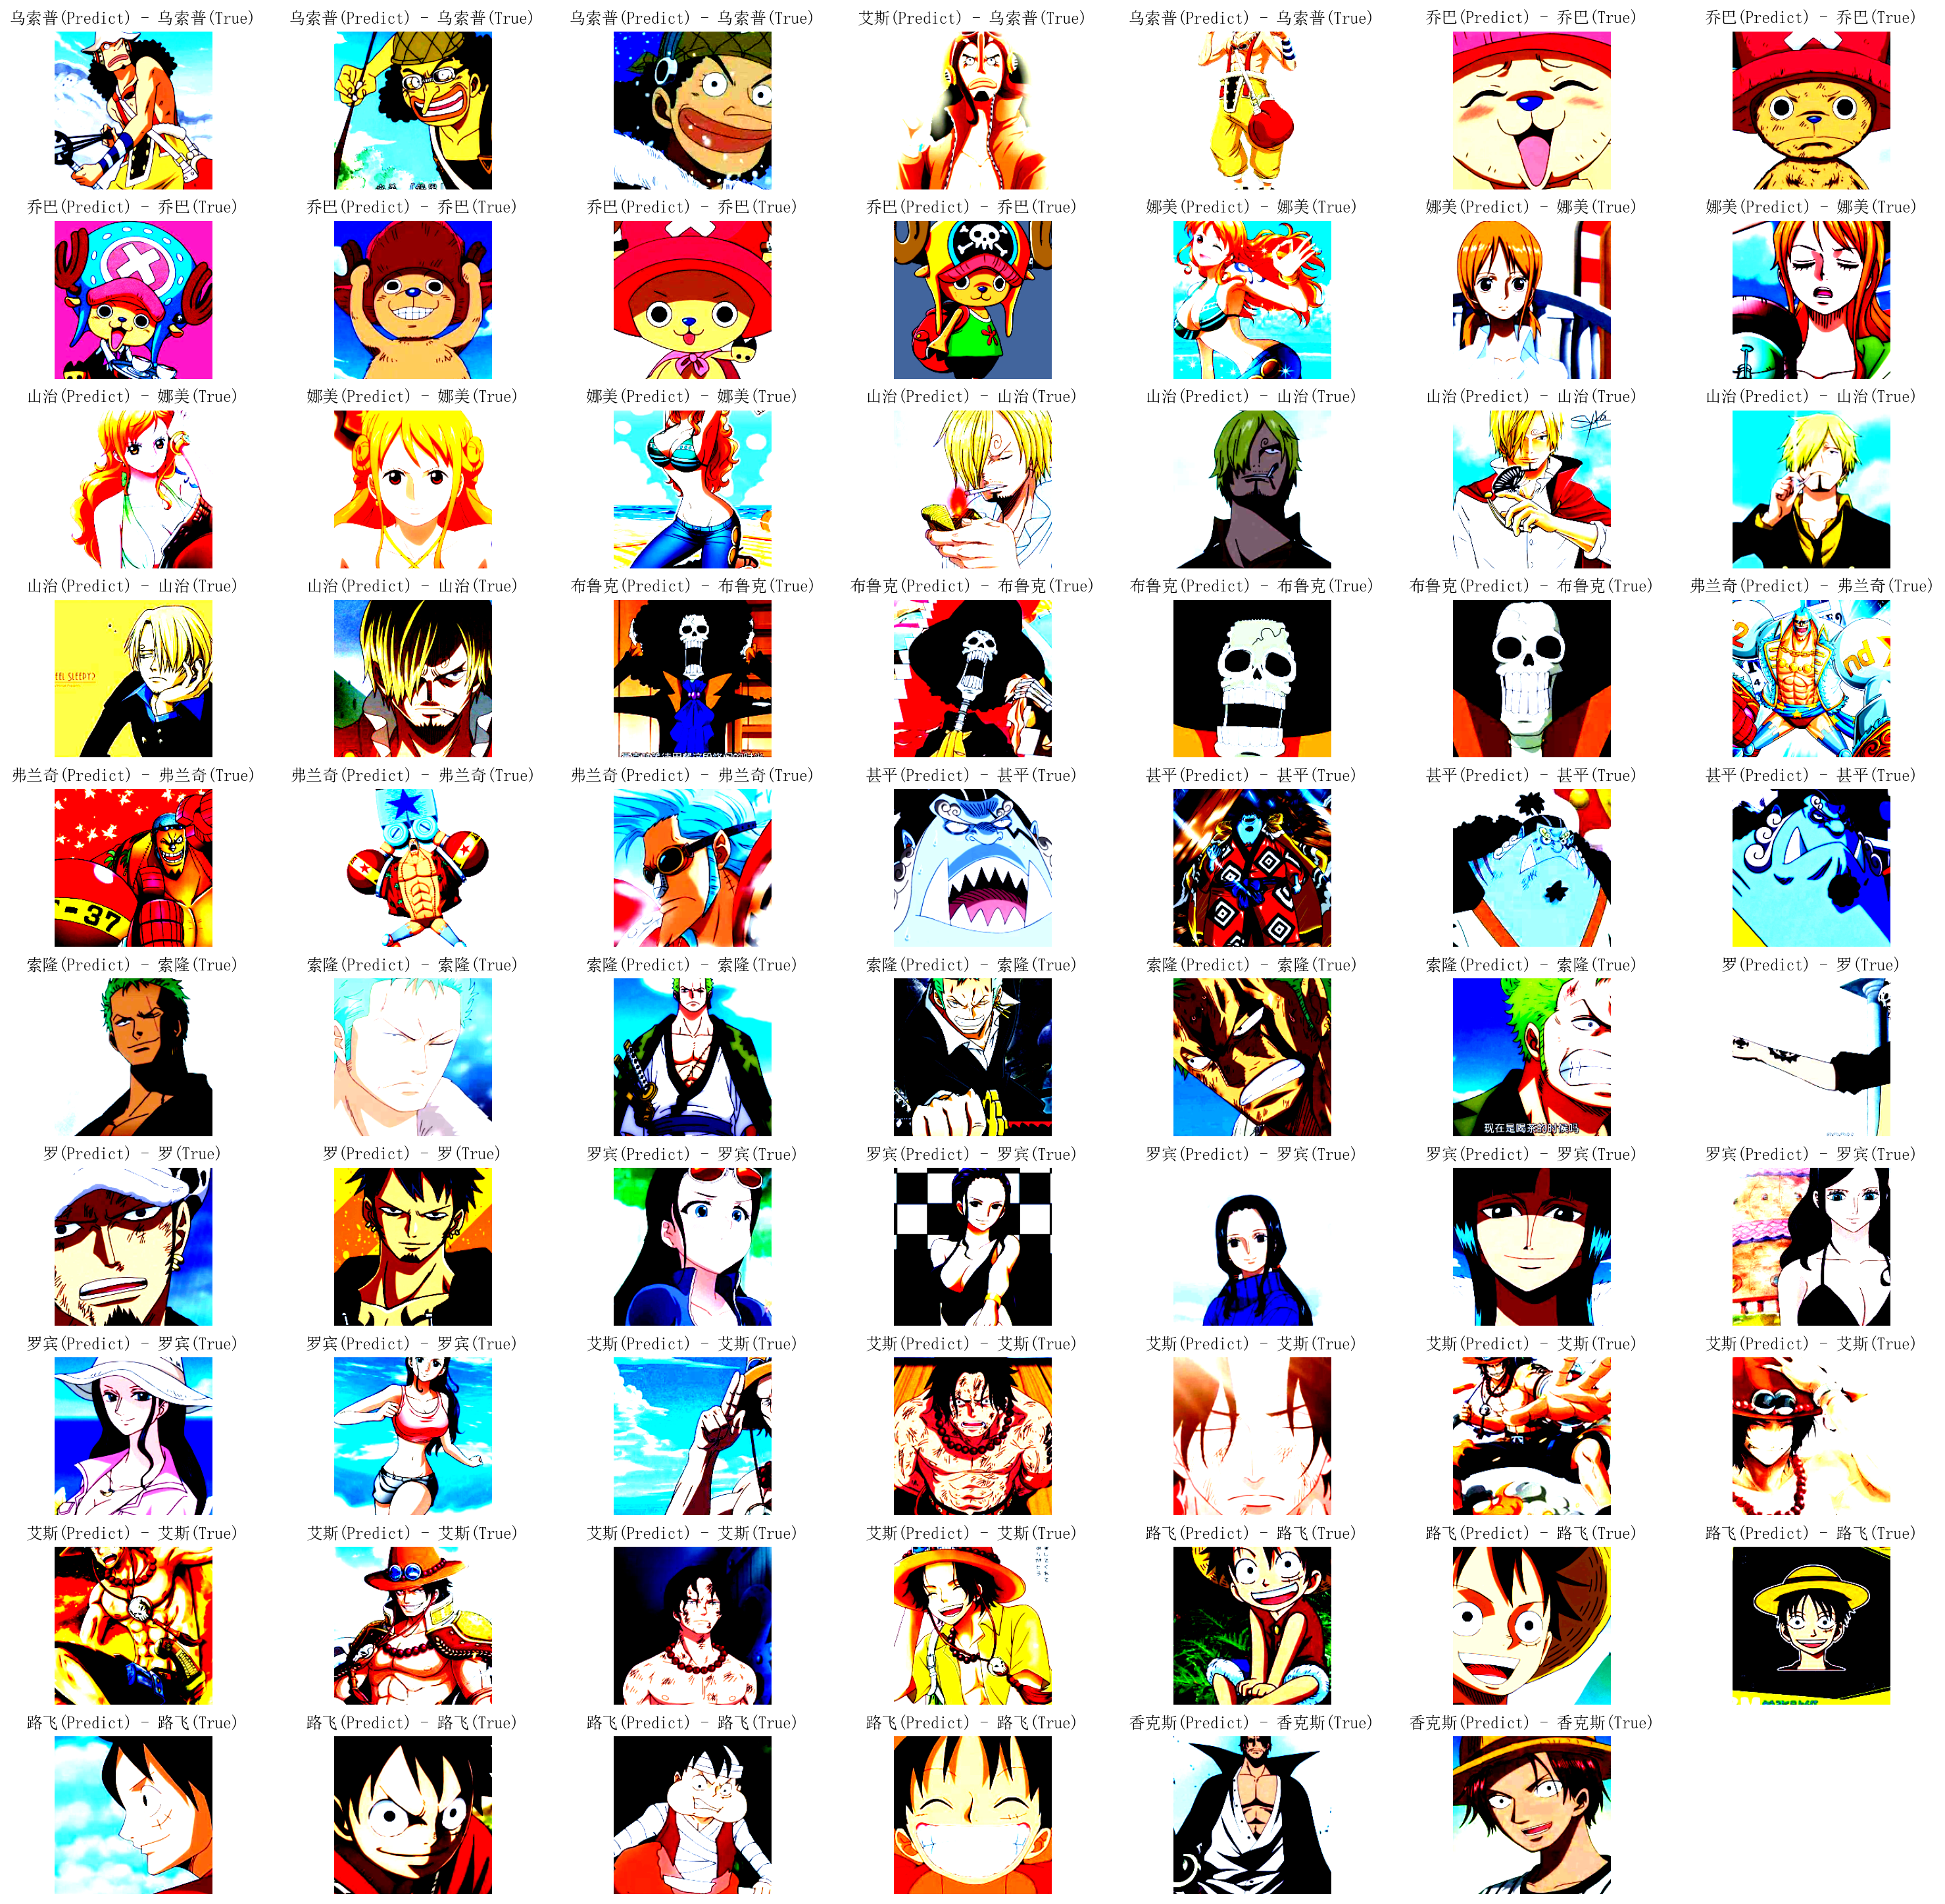

In [75]:
plt.figure(figsize=(25, 25), dpi=150)
cnt = 1
with torch.no_grad():
    for img, label in validate_dataset:
        shape = img.shape
        output = torch.squeeze(model(img.reshape(1, shape[0], shape[1], shape[2])))
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()
        # print(class_indice[str(predict_cla)], predict[predict_cla].numpy(), class_indice[str(label)])
        plt.subplot(10, 7, cnt)
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title("%s(Predict) - %s(True)" % (class_indice[str(predict_cla)], class_indice[str(label)]))
        plt.axis("off")
        cnt += 1
        if cnt == 70:
            break
plt.show()

In [77]:
import cv2

In [135]:
for img, lable in validate_loader:
    print(img.dtype)
    break

torch.float32


In [137]:
def read_img(img_path):
    img = cv2.imread(img_path)
    b, g, r = cv2.split(img)
    return cv2.merge([r, g, b])

img_path = "../imgs/test.jpg"
img = read_img(img_path)

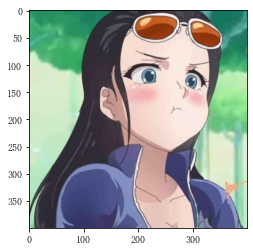

In [138]:
plt.imshow(img)
plt.show()

In [146]:
def img_preprocess(img):
    img_pil = torchvision.transforms.ToPILImage()(img)
    data_transform = transforms.Compose([transforms.Resize(256),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    img2 = data_transform(img_pil)
    img_exp = np.expand_dims(img2, axis=0)
    img_tensor = torch.tensor(img_exp, dtype=torch.float32)
    return img_tensor

In [147]:
img_pre = img_preprocess(img)
img_pre

tensor([[[[-1.3815, -1.2617, -1.1760,  ..., -1.5870, -1.5014, -1.4672],
          [-1.3302, -1.2274, -1.1418,  ..., -1.5357, -1.4500, -1.4158],
          [-1.2445, -1.1760, -1.0733,  ..., -1.5185, -1.4158, -1.3644],
          ...,
          [-1.3473, -1.3302, -1.3302,  ..., -0.7137, -0.5938,  0.1083],
          [-1.3644, -1.3473, -1.3130,  ..., -0.7137, -0.7137, -0.0801],
          [-1.3644, -1.3302, -1.3302,  ..., -0.7137, -0.7308, -0.2856]],

         [[ 0.5903,  0.7129,  0.8004,  ...,  0.0651,  0.0826,  0.1001],
          [ 0.6429,  0.7479,  0.8354,  ...,  0.1001,  0.0826,  0.1176],
          [ 0.7304,  0.8004,  0.9055,  ...,  0.1176,  0.1001,  0.1352],
          ...,
          [-1.2654, -1.2479, -1.2479,  ..., -0.4776, -0.3725,  0.3277],
          [-1.3004, -1.2829, -1.2479,  ..., -0.4776, -0.4951,  0.1527],
          [-1.3004, -1.2654, -1.2654,  ..., -0.4776, -0.4951, -0.0399]],

         [[-0.1312, -0.0092,  0.0779,  ..., -0.0790, -0.0790, -0.0615],
          [-0.1138, -0.0092,  

In [157]:
predict_prob = model(img_pre)
print(predict_prob)
predict_clf = torch.argmax(predict_prob).numpy()
print(class_indice[str(predict_clf)])

tensor([[-0.6286,  0.1253, -0.7064, -0.1289, -1.2234, -2.1439, -2.4400, -0.9451,
         -0.8499,  8.6504, -0.1853, -0.2139, -0.5802]],
       grad_fn=<AddmmBackward>)
罗宾


In [162]:
def predict(model, img_path):
    img_raw = read_img(img_path)
    img_pre = img_preprocess(img_raw)
    predict_prob = model(img_pre)
    predict_clf = torch.argmax(predict_prob).numpy()
    return class_indice[str(predict_clf)]

In [163]:
predict(model, "../imgs/test2.jpg")

'路飞'